# Lab 2: Inference in Graphical Models

### Machine Learning 2 (2016/2017)

* The lab exercises should be made in groups of two people or individually.
* The hand-in deadline is Wednesday, May 10, 23:59.
* Assignment should be sent to p.j.j.p.versteeg@uva.nl. The subject line of your email should be "[ML2_2017] lab#_lastname1\_lastname2". 
* Put your and your teammates' names in the body of the email
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file follows the same rule as the subject line. For example, if the subject line is "[ML2_2017] lab02\_Bongers\_Blom", the attached file should be "lab02\_Bongers\_Blom.ipynb". Only use underscores ("\_") to connect names, otherwise the files cannot be parsed.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please ask or e-mail Philip.
* For some of the questions, you can write the code directly in the first code cell that provides the class structure.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* NOTE: test your code and make sure we can run your notebook / scripts!

### Introduction
In this assignment, we will implement the sum-product and max-sum algorithms for factor graphs over discrete variables. The relevant theory is covered in chapter 8 of Bishop's PRML book, in particular section 8.4. Read this chapter carefuly before continuing!

We will first implement sum-product and max-sum and apply it to a simple poly-tree structured factor graph for medical diagnosis. Then, we will implement a loopy version of the algorithms and use it for image denoising.

For this assignment we recommended you stick to numpy ndarrays (constructed with np.array, np.zeros, np.ones, etc.) as opposed to numpy matrices, because arrays can store n-dimensional arrays whereas matrices only work for 2d arrays. We need n-dimensional arrays in order to store conditional distributions with more than 1 conditioning variable. If you want to perform matrix multiplication on arrays, use the np.dot function; all infix operators including *, +, -, work element-wise on arrays.

## Part 1: The sum-product algorithm

We will implement a datastructure to store a factor graph and to facilitate computations on this graph. Recall that a factor graph consists of two types of nodes, factors and variables. Below you will find some classes for these node types to get you started. Carefully inspect this code and make sure you understand what it does; you will have to build on it later.

In [1]:
import numpy as np

In [2]:
%pylab inline
class Node(object):
    """
    Base-class for Nodes in a factor graph. Only instantiate sub-classes of Node.
    """
    def __init__(self, name):
        # A name for this Node, for printing purposes
        self.name = name
        
        # Neighbours in the graph, identified with their index in this list.
        # i.e. self.neighbours contains neighbour 0 through len(self.neighbours) - 1.
        self.neighbours = []
        
        # Reset the node-state (not the graph topology)
        self.reset()
        
    def reset(self):
        # Incoming messages; a dictionary mapping neighbours to messages.
        # That is, it maps  Node -> np.ndarray.
        self.in_msgs = {}
        
        # A set of neighbours for which this node has pending messages.
        # We use a python set object so we don't have to worry about duplicates.
        self.pending = set([])

    def add_neighbour(self, nb):
        self.neighbours.append(nb)

    def send_sp_msg(self, other):
        # To be implemented in subclass.
        raise Exception('Method send_sp_msg not implemented in base-class Node')
   
    def send_ms_msg(self, other):
        # To be implemented in subclass.
        raise Exception('Method send_ms_msg not implemented in base-class Node')
    
    def receive_msg(self, other, msg):
        # Store the incomming message, replacing previous messages from the same node
        self.in_msgs[other] = msg
        print("received msg ", other.name, self.name, msg)

        list_pending  = [n for n in self.neighbours if n is not other] # Make list of all other neighbouring nodes as pening
        
        # Remove for each in list_pending if not all messages needed received
        #for check_node in list_pending:
        #    in_neighbours = ([n for n in check_node.neighbours if n is not other])
        #    if sum([n in self.in_msgs.keys() for n in in_neighbours]) != len(in_neighbours):
        #        list_pending.remove(check_node)
        for check_node in list_pending:
            in_neighbours = ([n for n in self.neighbours if n is not check_node])
            if sum([n in self.in_msgs.keys() for n in in_neighbours]) != len(in_neighbours):
                list_pending.remove(check_node)

        # Update set of pending nodes
        set_pending_neighbours = set(list_pending)
        self.pending.update(set_pending_neighbours)
    
    def __str__(self):
        # This is printed when using 'print node_instance'
        return self.name


class Variable(Node):
    def __init__(self, name, num_states):
        """
        Variable node constructor.
        Args:
            name: a name string for this node. Used for printing. 
            num_states: the number of states this variable can take.
            Allowable states run from 0 through (num_states - 1).
            For example, for a binary variable num_states=2,
            and the allowable states are 0, 1.
        """
        self.num_states = num_states
        
        # Call the base-class constructor
        super(Variable, self).__init__(name)
    
    def set_observed(self, observed_state):
        """
        Set this variable to an observed state.
        Args:
            observed_state: an integer value in [0, self.num_states - 1].
        """
        # Observed state is represented as a 1-of-N variable
        # Could be 0.0 for sum-product, but log(0.0) = -inf so a tiny value is preferable for max-sum
        self.observed_state[:] = 0.000001
        self.observed_state[observed_state] = 1.0
        
    def set_latent(self):
        """
        Erase an observed state for this variable and consider it latent again.
        """
        # No state is preferred, so set all entries of observed_state to 1.0
        # Using this representation we need not differentiate between observed and latent
        # variables when sending messages.
        self.observed_state[:] = 1.0
        
    def reset(self):
        super(Variable, self).reset()
        self.observed_state = np.ones(self.num_states)
        
    def marginal(self, Z=None): #send_sp_msg for variable node class
        in_neighbours = ([n for n in self.neighbours])
        #check .name argument
        assert sum([n in self.in_msgs.keys() for n in in_neighbours]) == len(in_neighbours), "Not all incoming message neighbours are in keys"

        if( sum(self.observed_state) == self.num_states):
            in_messages = [self.in_msgs[n] for n in self.neighbours]   # List of all factor in-messages to variable
            # Each category in message is multiplied with the same category in all other in_messages, element-wise
            marginal = np.ones(self.num_states)
            for i in range(len(in_messages)):
                marginal = np.multiply(marginal,in_messages[i])

            if Z==None:
                Z = sum(marginal)
            marginal = 1/Z * marginal
        
        else:
            marginal = np.round(self.observed_state)

        return marginal, Z

    def send_sp_msg(self,other): #send_sp_msg for variable node class
    
        in_neighbours = ([n for n in self.neighbours if n is not other])
        if sum([n in self.in_msgs.keys() for n in in_neighbours]) == len(in_neighbours):
        
            if len(self.neighbours) == 1:
                out_message = np.ones(self.num_states)
            else:
                in_messages = [self.in_msgs[n] for n in self.neighbours if n is not other]   # List of factor in-messages to variable except the one from target factor

                # Each category in message is multiplied with the same category in all other in_messages, element-wise (minus other)
                out_message = np.ones(self.num_states)
                for i in range(len(in_messages)):
                    out_message = np.multiply(out_message,in_messages[i])     
            
            out_message *= self.observed_state
            other.receive_msg(other=self, msg = out_message)

    def send_ms_msg(self,other): #send_ms_msg for variable node class

        in_neighbours = ([n for n in self.neighbours if n is not other])
        if sum([n in self.in_msgs.keys() for n in in_neighbours]) == len(in_neighbours):

            if len(self.neighbours) == 1:
                out_message = np.zeros(self.num_states)
            else:
                in_messages = [self.in_msgs[n] for n in self.neighbours if n is not other]   # List of factor in-messages to variable except the one from target factor

                # Each category in message is multiplied with the same category in all other in_messages, element-wise (minus other)
                out_message = np.zeros(self.num_states)
                for i in range(len(in_messages)):
                    out_message = out_message + in_messages[i]

            out_message *= self.observed_state
            other.receive_msg(other=self, msg = out_message)

class Factor(Node):
    def __init__(self, name, f, neighbours):
        """
        Factor node constructor.
        Args:
            name: a name string for this node. Used for printing
            f: a numpy.ndarray with N axes, where N is the number of neighbours.
               That is, the axes of f correspond to variables, and the index along that axes corresponds to a value of that variable.
               Each axis of the array should have as many entries as the corresponding neighbour variable has states.
            neighbours: a list of neighbouring Variables. Bi-directional connections are created.
        """
        # Call the base-class constructor
        super(Factor, self).__init__(name)

        assert len(neighbours) == f.ndim, 'Factor function f should accept as many arguments as this Factor node has neighbours'
        
        for nb_ind in range(len(neighbours)):
            nb = neighbours[nb_ind]
            assert f.shape[nb_ind] == nb.num_states, 'The range of the factor function f is invalid for input %i %s' % (nb_ind, nb.name)
            self.add_neighbour(nb)
            nb.add_neighbour(self)

        self.f = f
        
    def send_sp_msg(self,other):

        in_neighbours = ([n for n in self.neighbours if n is not other])
        if sum([n in self.in_msgs.keys() for n in in_neighbours]) == len(in_neighbours):

            if len(self.neighbours) == 1:
                out_message = self.f
            else:
                in_messages    = [self.in_msgs[n] for n in self.neighbours if n is not other]   # List of in-message 1x2 arrays to factor
                no_in_messages = len(in_messages)               # Number of messages received (from sending nodes)
                b_index        = list(range(0,no_in_messages))  # If our hypthesis is correct
                a_index        = [self.neighbours.index(n) for n in self.neighbours if n is not other] # Index of sending neighbours
                outer_prod     = np.multiply.reduce(np.ix_(*in_messages)) 
                out_message    = tensordot(a = self.f, b = outer_prod, axes= (a_index, b_index) )

            other.receive_msg(other=self, msg = out_message)

    def send_ms_msg(self,other): #Factor to variable (MS)

        in_neighbours = ([n for n in self.neighbours if n is not other])
        if sum([n in self.in_msgs.keys() for n in in_neighbours]) == len(in_neighbours):

            if len(self.neighbours) == 1:
                out_message = np.log(self.f)
            else:
                in_messages    = [self.in_msgs[n] for n in self.neighbours if n is not other]   # List of in-message 1x2 arrays to factor
                no_in_messages = len(in_messages)               # Number of messages received (from sending nodes)

                S = in_messages[0]
                if (no_in_messages > 1):
                    S = np.add.outer( in_messages[0], in_messages[1])
                if (no_in_messages > 2):
                    for i in range(2,no_in_messages):
                        print(i, in_messages)
                        S = np.add.outer( in_messages[i], S)

                ind = self.neighbours.index(other)
                ar  = self.f
                out_message = np.zeros(other.num_states)
                for i in range(ar.shape[ind]):
                    idx = [slice(None)] * ar.ndim             # inintialize the index with the same length 
                                                              # as the dimensions
                    idx[ind] = i                              # modify the index of the desired dimension
                    log_ar = np.log(ar[tuple(idx)])
                    out_message[i] = np.max(log_ar + S)

            other.receive_msg(other=self, msg = out_message)


Populating the interactive namespace from numpy and matplotlib


### 1.1 Instantiate network (10 points)
Convert the directed graphical model ("Bayesian Network") shown below to a factor graph. Instantiate this graph by creating Variable and Factor instances and linking them according to the graph structure. 
To instantiate the factor graph, first create the Variable nodes and then create Factor nodes, passing a list of neighbour Variables to each Factor.
Use the following prior and conditional probabilities.

$$
p(\verb+Influenza+) = 0.05 \\\\
p(\verb+Smokes+) = 0.2 \\\\
$$

$$
p(\verb+SoreThroat+ = 1 | \verb+Influenza+ = 1) = 0.3 \\\\
p(\verb+SoreThroat+ = 1 | \verb+Influenza+ = 0) = 0.001 \\\\
p(\verb+Fever+ = 1| \verb+Influenza+ = 1) = 0.9 \\\\
p(\verb+Fever+ = 1| \verb+Influenza+ = 0) = 0.05 \\\\
p(\verb+Bronchitis+ = 1 | \verb+Influenza+ = 1, \verb+Smokes+ = 1) = 0.99 \\\\
p(\verb+Bronchitis+ = 1 | \verb+Influenza+ = 1, \verb+Smokes+ = 0) = 0.9 \\\\
p(\verb+Bronchitis+ = 1 | \verb+Influenza+ = 0, \verb+Smokes+ = 1) = 0.7 \\\\
p(\verb+Bronchitis+ = 1 | \verb+Influenza+ = 0, \verb+Smokes+ = 0) = 0.0001 \\\\
p(\verb+Coughing+ = 1| \verb+Bronchitis+ = 1) = 0.8 \\\\
p(\verb+Coughing+ = 1| \verb+Bronchitis+ = 0) = 0.07 \\\\
p(\verb+Wheezing+ = 1| \verb+Bronchitis+ = 1) = 0.6 \\\\
p(\verb+Wheezing+ = 1| \verb+Bronchitis+ = 0) = 0.001 \\\\
$$

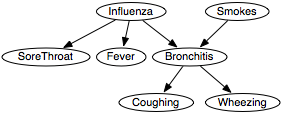

In [3]:
from IPython.core.display import Image 
Image(filename='bn.png') 

In [4]:
v_I   = Variable(name = "v_I",  num_states = 2)
v_ST  = Variable(name = "v_ST", num_states = 2)
v_F   = Variable(name = "v_F",  num_states = 2)
v_B   = Variable(name = "v_B",  num_states = 2)
v_SM  = Variable(name = "v_SM", num_states = 2)
v_C   = Variable(name = "v_C",  num_states = 2)
v_W   = Variable(name = "v_W",  num_states = 2)
###
p_f_a = np.array( [0.05,0.95] )
p_f_b = np.array( [[0.3,0.7],      #ST = 1
                   [0.001,0.999]]) #ST = 0 
p_f_c = np.array( [[0.90,0.10],[0.05,0.95]])
p_f_d = np.array( [     #B
                    [   #I
                      [0.99,0.01],
                      [0.9,0.1]] ,
                    [
                      [0.7,0.3],
                      [0.0001,0.9999]
                    ]
                   ]
                )
p_f_e = np.array( [0.2,0.8])
p_f_f = np.array( [[0.8,0.2],[0.07,0.93]])
p_f_g = np.array( [[0.6,0.4],[0.001,0.999]])
###
f_a = Factor(name = "f_a", f=p_f_a, neighbours = [v_I])
f_b = Factor(name = "f_b", f=p_f_b, neighbours = [v_I,v_ST])
f_c = Factor(name = "f_c", f=p_f_c, neighbours = [v_I,v_F])
f_d = Factor(name = "f_d", f=p_f_d, neighbours = [v_I,v_SM,v_B])
f_e = Factor(name = "f_e", f=p_f_e, neighbours = [v_SM])
f_f = Factor(name = "f_f", f=p_f_f, neighbours = [v_B,v_C])
f_g = Factor(name = "f_g", f=p_f_g, neighbours = [v_B,v_W])

### 1.2 Factor to variable messages (20 points)
Write a method `send_sp_msg(self, other)` for the Factor class, that checks if all the information required to pass a message to Variable `other` is present, computes the message and sends it to `other`. "Sending" here simply means calling the `receive_msg` function of the receiving node (we will implement this later). The message itself should be represented as a numpy array (np.array) whose length is equal to the number of states of the variable.

An elegant and efficient solution can be obtained using the n-way outer product of vectors. This product takes n vectors $\mathbf{x}^{(1)}, \ldots, \mathbf{x}^{(n)}$ and computes a $n$-dimensional tensor (ndarray) whose element $i_0,i_1,...,i_n$ is given by $\prod_j \mathbf{x}^{(j)}_{i_j}$. In python, this is realized as `np.multiply.reduce(np.ix_(*vectors))` for a python list `vectors` of 1D numpy arrays. Try to figure out how this statement works -- it contains some useful functional programming techniques. Another function that you may find useful in computing the message is `np.tensordot`.

### 1.3 Variable to factor messages (10 points)

Write a method `send_sp_message(self, other)` for the Variable class, that checks if all the information required to pass a message to Variable var is present, computes the message and sends it to factor.

### 1.4 Compute marginal (10 points)
Later in this assignment, we will implement message passing schemes to do inference. Once the message passing has completed, we will want to compute local marginals for each variable.
Write the method `marginal` for the Variable class, that computes a marginal distribution over that node.

### 1.5 Receiving messages (10 points)
In order to implement the loopy and non-loopy message passing algorithms, we need some way to determine which nodes are ready to send messages to which neighbours. To do this in a way that works for both loopy and non-loopy algorithms, we make use of the concept of "pending messages", which is explained in Bishop (8.4.7): 
"we will say that a (variable or factor)
node a has a message pending on its link to a node b if node a has received any
message on any of its other links since the last time it send (sic) a message to b. Thus,
when a node receives a message on one of its links, this creates pending messages
on all of its other links."

Keep in mind that for the non-loopy algorithm, nodes may not have received any messages on some or all of their links. Therefore, before we say node a has a pending message for node b, we must check that node a has received all messages needed to compute the message that is to be sent to b.

Modify the function `receive_msg`, so that it updates the self.pending variable as described above. The member self.pending is a set that is to be filled with Nodes to which self has pending messages. Modify the `send_msg` functions to remove pending messages as they are sent.

### 1.6 Inference Engine (10 points)
Write a function `sum_product(node_list)` that runs the sum-product message passing algorithm on a tree-structured factor graph with given nodes. The input parameter `node_list` is a list of all Node instances in the graph, which is assumed to be ordered correctly. That is, the list starts with a leaf node, which can always send a message. Subsequent nodes in `node_list` should be capable of sending a message when the pending messages of preceding nodes in the list have been sent. The sum-product algorithm then proceeds by passing over the list from beginning to end, sending all pending messages at the nodes it encounters. Then, in reverse order, the algorithm traverses the list again and again sends all pending messages at each node as it is encountered. For this to work, you must initialize pending messages for all the leaf nodes, e.g. `influenza_prior.pending.add(influenza)`, where `influenza_prior` is a Factor node corresponding the the prior, `influenza` is a Variable node and the only connection of `influenza_prior` goes to `influenza`.




In [5]:
def sum_product(node_list):
    k = 0
    for i in range(len(node_list)):
        for j in range(len(node_list[i].pending)):
            node_list[i].send_sp_msg(list(node_list[i].pending)[j])
            k = k+1
    print("reversing")        
    node_list.reverse()
    for i in range(len(node_list)):
        for j in range(len(node_list[i].pending)):
            node_list[i].send_sp_msg(list(node_list[i].pending)[j])
            k = k+1
    print("Number of mesages passing attempts: ", k)

In [6]:
# Set node input order
input_node_order = list([f_a,f_e,v_SM,v_C,f_f,v_W,f_g,v_B,f_d,v_ST,f_b,v_I,f_c,v_F])

# Initialize leaf nodes
f_a.pending.add(v_I)
f_e.pending.add(v_SM)
v_C.pending.add(f_f)
v_W.pending.add(f_g)
v_ST.pending.add(f_b)
v_F.pending.add(f_c)

# Run SP algorithm
sum_product(input_node_order)

received msg  f_a v_I [ 0.05  0.95]
received msg  f_e v_SM [ 0.2  0.8]
received msg  v_SM f_d [ 0.2  0.8]
received msg  v_C f_f [ 1.  1.]
received msg  f_f v_B [ 1.  1.]
received msg  v_W f_g [ 1.  1.]
received msg  f_g v_B [ 1.  1.]
received msg  v_B f_d [ 1.  1.]
received msg  f_d v_I [ 1.  1.]
received msg  v_ST f_b [ 1.  1.]
received msg  f_b v_I [ 1.  1.]
received msg  v_I f_c [ 0.05  0.95]
received msg  f_c v_F [ 0.0925  0.9075]
received msg  v_F f_c [ 1.  1.]
reversing
received msg  v_F f_c [ 1.  1.]
received msg  f_c v_I [ 1.  1.]
received msg  f_c v_F [ 0.0925  0.9075]
received msg  v_I f_d [ 0.05  0.95]
received msg  v_I f_a [ 1.  1.]
received msg  v_I f_c [ 0.05  0.95]
received msg  v_I f_b [ 0.05  0.95]
received msg  f_b v_I [ 1.  1.]
received msg  f_b v_ST [ 0.01595  0.98405]
received msg  v_ST f_b [ 1.  1.]
received msg  f_d v_B [ 0.178976  0.821024]
received msg  f_d v_I [ 1.  1.]
received msg  f_d v_SM [ 1.  1.]
received msg  v_B f_f [ 0.178976  0.821024]
received msg  

In [7]:
## Print all marginals
all_var = list([v_I,v_SM,v_B,v_ST,v_F,v_C,v_W])
margs = np.arange(14).reshape(7, 2)
for i in range(len(all_var)):
    print(all_var[i], all_var[i].marginal()[0])

v_I [ 0.05  0.95]
v_SM [ 0.2  0.8]
v_B [ 0.178976  0.821024]
v_ST [ 0.01595  0.98405]
v_F [ 0.0925  0.9075]
v_C [ 0.20065248  0.79934752]
v_W [ 0.10820662  0.89179338]


### 1.7 Observed variables and probabilistic queries (15 points)
We will now use the inference engine to answer probabilistic queries. That is, we will set certain variables to observed values, and obtain the marginals over latent variables. We have already provided functions `set_observed` and `set_latent` that manage a member of Variable called `observed_state`. Modify the `Variable.send_msg` and `Variable.marginal` routines that you wrote before, to use `observed_state` so as to get the required marginals when some nodes are observed.

In [8]:
# Set coughing and wheezing to observed
v_C.set_observed(0)
v_W.set_observed(0)
# Re-run SP 
sum_product(input_node_order)

received msg  v_F f_c [ 1.  1.]
received msg  f_c v_I [ 1.  1.]
received msg  f_c v_F [ 0.0925  0.9075]
received msg  v_I f_a [ 1.  1.]
received msg  v_I f_c [ 0.05  0.95]
received msg  v_I f_d [ 0.05  0.95]
received msg  v_I f_b [ 0.05  0.95]
received msg  f_b v_I [ 1.  1.]
received msg  f_b v_ST [ 0.01595  0.98405]
received msg  v_ST f_b [ 1.  1.]
received msg  f_d v_B [ 0.178976  0.821024]
received msg  f_d v_I [ 1.  1.]
received msg  f_d v_SM [ 1.  1.]
received msg  v_B f_f [ 0.178976  0.821024]
received msg  v_B f_d [ 1.  1.]
received msg  v_B f_g [ 0.178976  0.821024]
received msg  f_g v_B [ 1.  1.]
received msg  f_g v_W [ 0.10820662  0.89179338]
received msg  v_W f_g [  1.00000000e+00   1.00000000e-06]
received msg  f_f v_C [ 0.20065248  0.79934752]
received msg  f_f v_B [ 1.  1.]
received msg  v_C f_f [  1.00000000e+00   1.00000000e-06]
received msg  v_SM f_d [ 0.2  0.8]
received msg  v_SM f_e [ 1.  1.]
received msg  f_e v_SM [ 0.2  0.8]
received msg  f_a v_I [ 0.05  0.95]
reve

In [9]:
# Print all marginals
all_var = list([v_I,v_SM,v_B,v_ST,v_F,v_C,v_W])
margs = np.arange(14).reshape(7, 2)
for i in range(len(all_var)):
    print(all_var[i], all_var[i].marginal()[0])

v_I [ 0.25629068  0.74370932]
v_SM [ 0.79794329  0.20205671]
v_B [  9.99330784e-01   6.69215727e-04]
v_ST [ 0.01595  0.98405]
v_F [ 0.26784708  0.73215292]
v_C [ 1.  0.]
v_W [ 1.  0.]


### 1.8 Sum-product and MAP states (5 points)
A maximum a posteriori state (MAP-state) is an assignment of all latent variables that maximizes the probability of latent variables given observed variables:
$$
\mathbf{x}_{\verb+MAP+} = \arg\max _{\mathbf{x}} p(\mathbf{x} | \mathbf{y})
$$
Could we use the sum-product algorithm to obtain a MAP state? If yes, how? If no, why not?


**ANSWER** The answer to this question depends on whether $\mathbf{x}$ is thought to be a scalar or a vector, leading to the MAP estimate for the conditional distribution of a single $x$ are several $x$ jointly. In the former case, the sum-product algorithm can be applied, for example by setting certain $y$ equal to observed values, running the algorithm, and then choosing for each $x$ the category that maximizes the probability to be observed. In the latter case, this procedure will not be successful, as it maximizes the marginal probability for a single $x$ instead of the vector. The max-sum algorithm is more suitable for this purpose.

## Part 2: The max-sum algorithm
Next, we implement the max-sum algorithm as described in section 8.4.5 of Bishop.

### 2.1 Factor to variable messages (10 points)
Implement the function `Factor.send_ms_msg` that sends Factor -> Variable messages for the max-sum algorithm. It is analogous to the `Factor.send_sp_msg` function you implemented before.

### 2.2 Variable to factor messages (10 points)
Implement the `Variable.send_ms_msg` function that sends Variable -> Factor messages for the max-sum algorithm.

### 2.3 Find a MAP state (10 points)

Using the same message passing schedule we used for sum-product, implement the max-sum algorithm. For simplicity, we will ignore issues relating to non-unique maxima. So there is no need to implement backtracking; the MAP state is obtained by a per-node maximization (eq. 8.98 in Bishop). Make sure your algorithm works with both latent and observed variables.

In [10]:
def max_sum(node_list):
    k = 0
    for i in range(len(node_list)):
        for j in range(len(node_list[i].pending)):
            node_list[i].send_ms_msg(list(node_list[i].pending)[j])
            k = k+1
    print("reversing")        
    node_list.reverse()
    for i in range(len(node_list)):
        for j in range(len(node_list[i].pending)):
            node_list[i].send_ms_msg(list(node_list[i].pending)[j])
            k = k+1
    print("Number of mesages passing attempts: ", k)

In [11]:
def MAP_state(var_list):
    map_state = np.zeros(len(var_list))
    S_list = [] 
    var_names = []
    for i in range(len(var_list)):
        if( sum(var_list[i].observed_state) == var_list[i].num_states) :
            in_messages = [var_list[i].in_msgs[n] for n in var_list[i].neighbours] 
            S = np.zeros(var_list[i].num_states)
            for j in range(len(in_messages)):
                S = S + in_messages[j]
            map_state[i] = np.argmax(S)
            S_list.append(S)
        else:
            map_state[i] = np.argmax(var_list[i].observed_state)
            S_list.append(None)
        var_names.append(var_list[i].name)
    
    for var_name, map_state_elem, s in zip(var_names, map_state, S_list):
        print('Variable {} has MAP state {} with sum {}'.format(var_name, map_state_elem, s))
    #return var_names, map_state, S_list


In [12]:
# Re-initialize set-up
###
v_I   = Variable(name = "v_I",  num_states = 2)
v_ST  = Variable(name = "v_ST", num_states = 2)
v_F   = Variable(name = "v_F",  num_states = 2)
v_B   = Variable(name = "v_B",  num_states = 2)
v_SM  = Variable(name = "v_SM", num_states = 2)
v_C   = Variable(name = "v_C",  num_states = 2)
v_W   = Variable(name = "v_W",  num_states = 2)
f_a = Factor(name = "f_a", f=p_f_a, neighbours = [v_I])
f_b = Factor(name = "f_b", f=p_f_b, neighbours = [v_I,v_ST])
f_c = Factor(name = "f_c", f=p_f_c, neighbours = [v_I,v_F])
f_d = Factor(name = "f_d", f=p_f_d, neighbours = [v_I,v_SM,v_B])
f_e = Factor(name = "f_e", f=p_f_e, neighbours = [v_SM])
f_f = Factor(name = "f_f", f=p_f_f, neighbours = [v_B,v_C])
f_g = Factor(name = "f_g", f=p_f_g, neighbours = [v_B,v_W])

# make a list of all variables
all_var = list([v_I,v_SM,v_B,v_ST,v_F,v_C,v_W])

# Set node input order
input_node_order = list([f_a,f_e,v_SM,v_C,f_f,v_W,f_g,v_B,f_d,v_ST,f_b,v_I,f_c,v_F])

# Initialize leaf nodes
f_a.pending.add(v_I)
f_e.pending.add(v_SM)
v_C.pending.add(f_f)
v_W.pending.add(f_g)
v_ST.pending.add(f_b)
v_F.pending.add(f_c)

In [13]:
# Run Max-Sum algorithm
max_sum(input_node_order)

received msg  f_a v_I [-2.99573227 -0.05129329]
received msg  f_e v_SM [-1.60943791 -0.22314355]
received msg  v_SM f_d [-1.60943791 -0.22314355]
received msg  v_C f_f [ 0.  0.]
received msg  f_f v_B [-0.22314355 -0.07257069]
received msg  v_W f_g [ 0.  0.]
received msg  f_g v_B [-0.51082562 -0.0010005 ]
received msg  v_B f_d [-0.73396918 -0.07357119]
received msg  f_d v_I [-1.06247324 -0.29681475]
received msg  v_ST f_b [ 0.  0.]
received msg  f_b v_I [-0.35667494 -0.0010005 ]
received msg  v_I f_c [-4.41488046 -0.34910854]
received msg  f_c v_F [-3.34484082 -0.40040184]
received msg  v_F f_c [ 0.  0.]
reversing
received msg  v_F f_c [ 0.  0.]
received msg  f_c v_F [-3.34484082 -0.40040184]
received msg  f_c v_I [-0.10536052 -0.05129329]
received msg  v_I f_b [-4.16356603 -0.39940134]
received msg  v_I f_a [-1.5245087  -0.34910854]
received msg  v_I f_d [-3.45776773 -0.10358709]
received msg  v_I f_c [-4.41488046 -0.34910854]
received msg  f_b v_ST [-5.36753884 -0.40040184]
received m

In [14]:
# Get MAP states for all variables
MAP_state(all_var)

Variable v_I has MAP state 1.0 with sum [-4.52024098 -0.40040184]
Variable v_SM has MAP state 1.0 with sum [-2.80366912 -0.40040184]
Variable v_B has MAP state 1.0 with sum [-2.80366912 -0.40040184]
Variable v_ST has MAP state 1.0 with sum [-5.36753884 -0.40040184]
Variable v_F has MAP state 1.0 with sum [-3.34484082 -0.40040184]
Variable v_C has MAP state 1.0 with sum [-2.80366912 -0.40040184]
Variable v_W has MAP state 1.0 with sum [-2.80366912 -0.40040184]


In [15]:
## Fixing observed values
## Re-initialize set-up
##
v_I   = Variable(name = "v_I",  num_states = 2)
v_ST  = Variable(name = "v_ST", num_states = 2)
v_F   = Variable(name = "v_F",  num_states = 2)
v_B   = Variable(name = "v_B",  num_states = 2)
v_SM  = Variable(name = "v_SM", num_states = 2)
v_C   = Variable(name = "v_C",  num_states = 2)
v_W   = Variable(name = "v_W",  num_states = 2)
f_a = Factor(name = "f_a", f=p_f_a, neighbours = [v_I])
f_b = Factor(name = "f_b", f=p_f_b, neighbours = [v_I,v_ST])
f_c = Factor(name = "f_c", f=p_f_c, neighbours = [v_I,v_F])
f_d = Factor(name = "f_d", f=p_f_d, neighbours = [v_I,v_SM,v_B])
f_e = Factor(name = "f_e", f=p_f_e, neighbours = [v_SM])
f_f = Factor(name = "f_f", f=p_f_f, neighbours = [v_B,v_C])
f_g = Factor(name = "f_g", f=p_f_g, neighbours = [v_B,v_W])

# make a list of all variables
all_var = list([v_I,v_SM,v_B,v_ST,v_F,v_C,v_W])

# Set node input order
input_node_order = list([f_a,f_e,v_SM,v_C,f_f,v_W,f_g,v_B,f_d,v_ST,f_b,v_I,f_c,v_F])

# Initialize leaf nodes
f_a.pending.add(v_I)
f_e.pending.add(v_SM)
v_C.pending.add(f_f)
v_W.pending.add(f_g)
v_ST.pending.add(f_b)
v_F.pending.add(f_c)

# Set coughing and wheezing to observed
#v_SM.set_observed(0)
#v_C.set_observed(0)
#v_W.set_observed(0)
#v_ST.set_observed(0)
#v_F.set_observed(0)
v_I.set_observed(0)
v_SM.set_observed(0)

max_sum(input_node_order)

received msg  f_a v_I [-2.99573227 -0.05129329]
received msg  f_e v_SM [-1.60943791 -0.22314355]
received msg  v_SM f_d [ -1.60943791e+00  -2.23143551e-07]
received msg  v_C f_f [ 0.  0.]
received msg  f_f v_B [-0.22314355 -0.07257069]
received msg  v_W f_g [ 0.  0.]
received msg  f_g v_B [-0.51082562 -0.0010005 ]
received msg  v_B f_d [-0.73396918 -0.07357119]
received msg  f_d v_I [-0.83932991 -0.07367142]
received msg  v_ST f_b [ 0.  0.]
received msg  f_b v_I [-0.35667494 -0.0010005 ]
received msg  v_I f_c [ -4.19173713e+00  -1.25965216e-07]
received msg  f_c v_F [-2.9957324  -0.05129342]
received msg  v_F f_c [ 0.  0.]
reversing
received msg  v_F f_c [ 0.  0.]
received msg  f_c v_F [-2.9957324  -0.05129342]
received msg  f_c v_I [-0.10536052 -0.05129329]
received msg  v_I f_a [ -1.30136537e+00  -1.25965216e-07]
received msg  v_I f_d [ -3.45776773e+00  -1.03587089e-07]
received msg  v_I f_c [ -4.19173713e+00  -1.25965216e-07]
received msg  v_I f_b [ -3.94042270e+00  -1.76258010e-07]

In [16]:
MAP_state(all_var)

Variable v_I has MAP state 0.0 with sum None
Variable v_SM has MAP state 0.0 with sum None
Variable v_B has MAP state 1.0 with sum [-2.70008214 -0.07367152]
Variable v_ST has MAP state 1.0 with sum [ -5.14439551e+00  -1.00067659e-03]
Variable v_F has MAP state 1.0 with sum [-2.9957324  -0.05129342]
Variable v_C has MAP state 1.0 with sum [-2.66036087 -0.07367152]
Variable v_W has MAP state 1.0 with sum [-2.70008214 -0.07367152]


## Part 3: Image Denoising and Loopy BP

Next, we will use a loopy version of max-sum to perform denoising on a binary image. The model itself is discussed in Bishop 8.3.3, but we will use loopy max-sum instead of Iterative Conditional Modes as Bishop does.

The following code creates some toy data: `im` is a quite large binary image and `test_im` is a smaller synthetic binary image. Noisy versions are also provided.

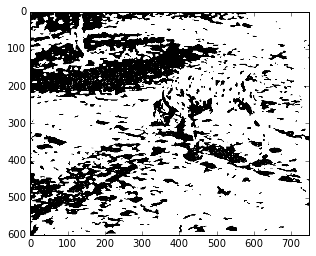

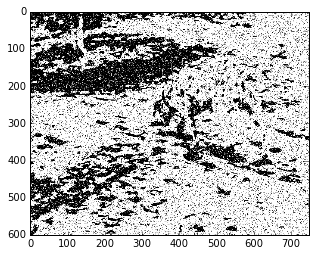

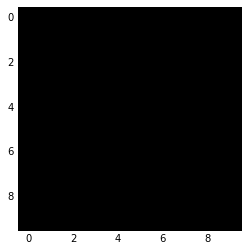

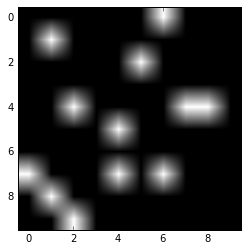

In [17]:
from pylab import imread, gray
# Load the image and binarize
im = np.mean(imread('dalmatian1.png'), axis=2) > 0.5
imshow(im)
gray()

# Add some noise
noise = np.random.rand(*im.shape) > 0.9
noise_im = np.logical_xor(noise, im)
figure()
imshow(noise_im)

test_im = np.zeros((10,10))
#test_im[5:8, 3:8] = 1.0
#test_im[5,5] = 1.0
figure()
imshow(test_im)

# Add some noise
noise = np.random.rand(*test_im.shape) > 0.9
noise_test_im = np.logical_xor(noise, test_im)
figure()
imshow(noise_test_im)

### 3.1 Construct factor graph (10 points)
Convert the Markov Random Field (Bishop, fig. 8.31) to a factor graph and instantiate it.

In [18]:
# YOUR ANSWER HERE

### 3.2 Loopy max-sum (10 points)
Implement the loopy max-sum algorithm, by passing messages from randomly chosen nodes iteratively until no more pending messages are created or a maximum number of iterations is reached. 

Think of a good way to initialize the messages in the graph.

In [19]:
# YOUR ANSWER hErE